##Importing Files

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import uniform, randint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.linear_model import LogisticRegression
import sklearn.ensemble as ske

from pprint import pprint
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root_path = 'drive/My Drive/Dataset_music/'  

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/Dataset_music/

features_30_sec.csv  features_3_sec.csv  genres_original


In [ ]:
df = pd.read_csv('drive/My Drive/Dataset_music/features_3_sec.csv')
df = df.drop(['harmony_mean','harmony_var'], axis = 1)
df.head(100)

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,blues.00009.5.wav,66149,0.318541,0.092254,0.

In [ ]:
print("Dataset has",df.shape)
df.label.value_counts().reset_index()

Dataset has (9990, 58)


,index,label
0,reggae,1000
1,blues,1000
2,metal,1000
3,jazz,1000
4,pop,1000
5,disco,999
6,rock,998
7,hiphop,998
8,classical,998
9,country,997


##Viusalize audio

In [ ]:
audio_fp = 'drive/My Drive/Dataset_music/genres_original/rock/rock.00001.wav'
audio_data, sr = librosa.load(audio_fp, offset=0, duration=30)
audio_data, _ = librosa.effects.trim(audio_data)
audio_data.shape

(661500,)

In [ ]:
collection = np.split(audio_data,10)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

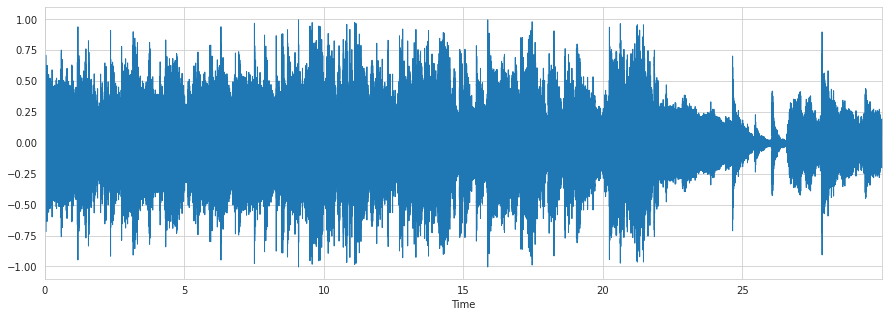

In [ ]:
plt.figure(figsize=(15,5))
lplt.waveplot(audio_data)
plt.show()


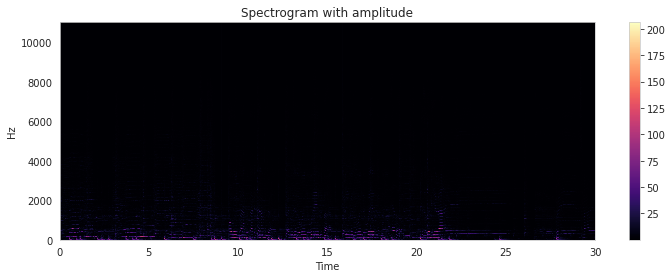

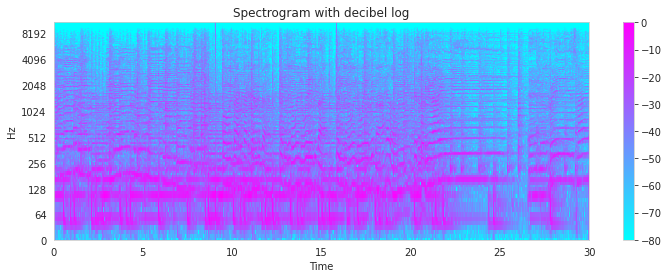

In [ ]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

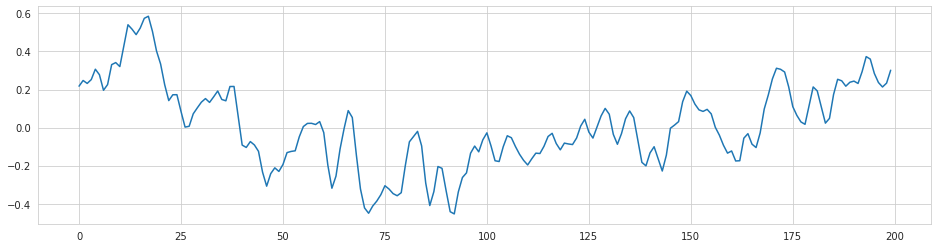

In [ ]:
# plot zoomed audio wave 
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

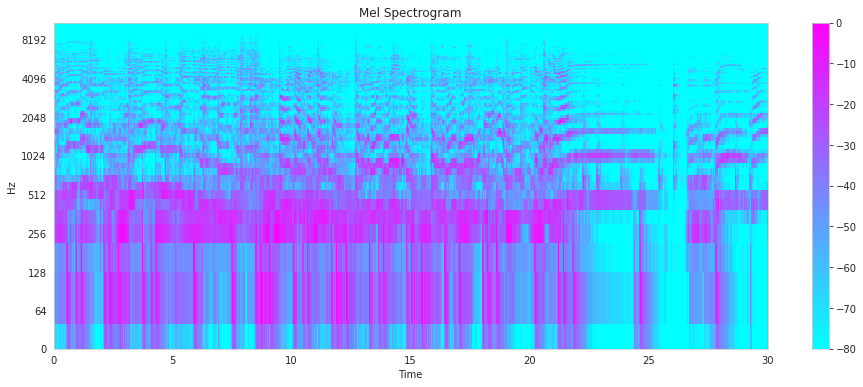

In [ ]:
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

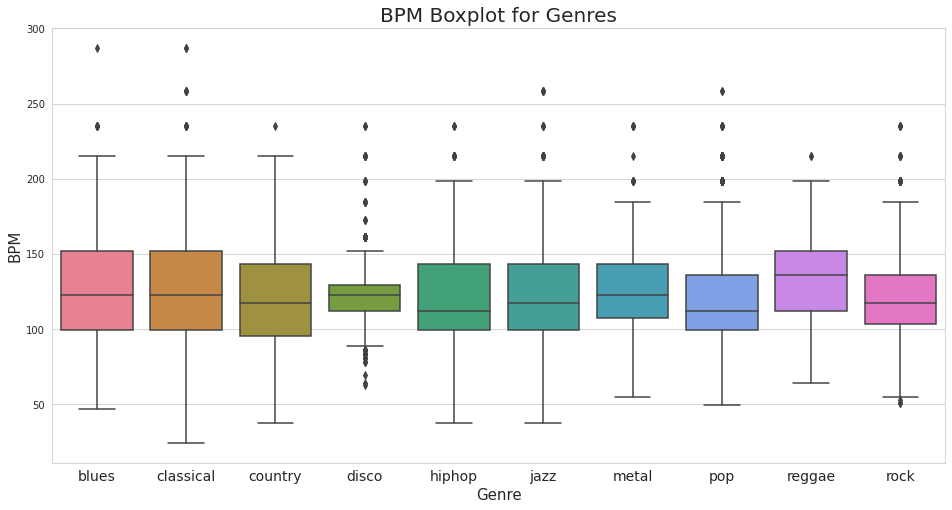

In [ ]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

In [ ]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# # Top 2 pca components
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(X)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# # concatenate with target label
# finalDf = pd.concat([principalDf, y], axis = 1)

# plt.figure(figsize = (16, 9))
# sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

# plt.title('PCA on Genres', fontsize = 20)
# plt.xticks(fontsize = 14)
# plt.yticks(fontsize = 10);
# plt.xlabel("Principal Component 1", fontsize = 15)
# plt.ylabel("Principal Component 2", fontsize = 15)
# plt.savefig("PCA_Scattert.png")

In [ ]:
# find all columns with any NA values
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


No null values in the dataset

There are no categorical variable as such. Hence, Dummy variable creation is not needed.

## Encode Genre Label¶


In [ ]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [ ]:
'''# update labels in df to index
df.label = [label_index[l] for l in df.label]'''

'# update labels in df to index\ndf.label = [label_index[l] for l in df.label]'

## Split Train Dev & Test Sets

In [ ]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [ ]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [ ]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [ ]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


## Scale the Features

In [ ]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)


In [ ]:
def predictProba(clf, X, dev=False):
    y_true = y_train
    if dev:
        X = X_dev[X.columns]
        y_true = y_dev
    y_pred_proba_X = clf.predict_proba(X)
    y_pred_X = clf.predict(X)
    fig, ax = plt.subplots(figsize=(6, 6))
    skm.plot_confusion_matrix(clf, X, y_true, display_labels=X.columns, cmap=plt.cm.Blues, xticks_rotation=90, ax=ax)
    plt.show()
    print(skm.classification_report(y_true, y_pred_X, digits=3))
    print("=====================================================")

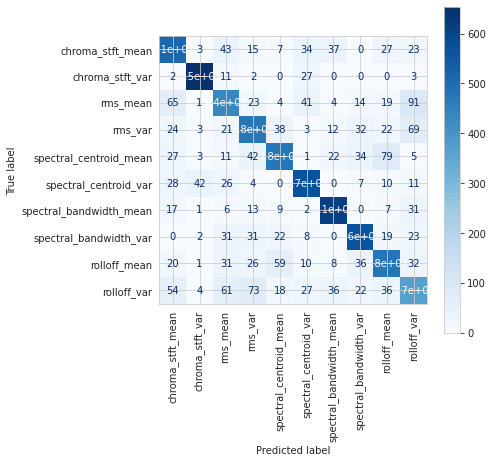

              precision    recall  f1-score   support

       blues      0.683     0.730     0.706       700
   classical      0.916     0.936     0.926       699
     country      0.644     0.625     0.634       698
       disco      0.675     0.680     0.677       699
      hiphop      0.752     0.680     0.714       699
        jazz      0.789     0.817     0.803       700
       metal      0.838     0.877     0.857       700
         pop      0.795     0.806     0.801       700
      reggae      0.685     0.681     0.683       700
        rock      0.560     0.526     0.542       698

    accuracy                          0.736      6993
   macro avg      0.734     0.736     0.734      6993
weighted avg      0.734     0.736     0.734      6993



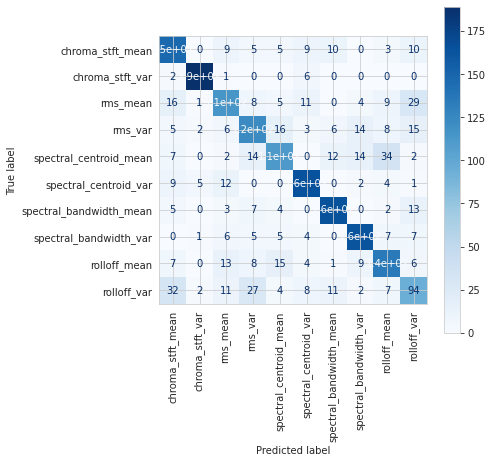

              precision    recall  f1-score   support

       blues      0.639     0.742     0.687       198
   classical      0.945     0.955     0.950       198
     country      0.644     0.579     0.610       197
       disco      0.624     0.621     0.623       198
      hiphop      0.675     0.569     0.617       197
        jazz      0.786     0.833     0.809       198
       metal      0.804     0.828     0.816       198
         pop      0.784     0.823     0.803       198
      reggae      0.646     0.682     0.663       198
        rock      0.531     0.475     0.501       198

    accuracy                          0.711      1978
   macro avg      0.708     0.711     0.708      1978
weighted avg      0.708     0.711     0.708      1978



In [ ]:
lr = LogisticRegression(random_state=seed)
lr.fit(X_train,y_train)
predictProba(lr, X_train)
predictProba(lr, X_train, dev=True)

## Permutation Importance Feature Selection

---



In [ ]:
pip install eli5

     |████████████████████████████████| 112kB 7.8MB/s 


In [ ]:

import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
perm = PermutationImportance(lr, random_state=seed).fit(X_train, y_train, n_iter=10)
print("Feature Importances using Permutation Importance")
eli5.show_weights(perm, feature_names = X_dev.columns.tolist())

Feature Importances using Permutation Importance


Weight,Feature
0.1722 ± 0.0118,spectral_centroid_mean
0.1473 ± 0.0085,spectral_bandwidth_mean
0.1452 ± 0.0094,mfcc1_mean
0.1366 ± 0.0086,rolloff_mean
0.1268 ± 0.0072,zero_crossing_rate_mean
0.1026 ± 0.0036,perceptr_var
0.0961 ± 0.0048,mfcc3_mean
0.0865 ± 0.0046,rms_mean
0.0859 ± 0.0025,chroma_stft_mean
0.0786 ± 0.0068,mfcc2_mean


### Plot Permutation Importances

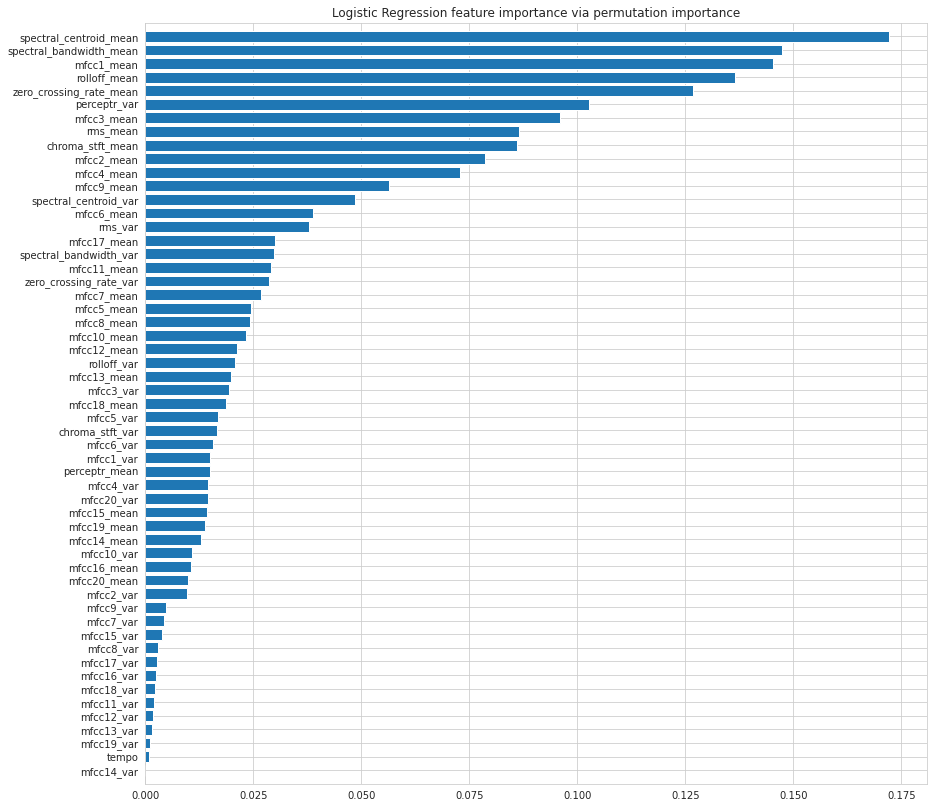

In [ ]:
# plot the permutation importances
perm_indices = np.argsort(perm.feature_importances_)[::-1]
perm_features = [X_dev.columns.tolist()[xx] for xx in perm_indices]
plt.figure(figsize=(14, 14))
plt.title("Logistic Regression feature importance via permutation importance")
plt.barh(range(X_dev.shape[1]), perm.feature_importances_[perm_indices])
plt.yticks(range(X_dev.shape[1]), perm_features)
plt.ylim([X_dev.shape[1], -1])
plt.show()

### Model Score using Permutation Importances

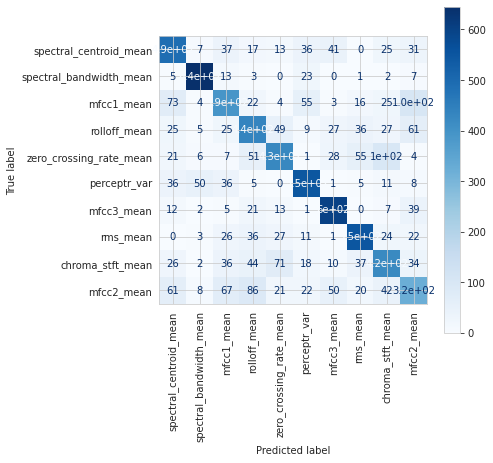

              precision    recall  f1-score   support

       blues      0.656     0.704     0.679       700
   classical      0.881     0.923     0.901       699
     country      0.608     0.560     0.583       698
       disco      0.604     0.622     0.613       699
      hiphop      0.683     0.609     0.644       699
        jazz      0.757     0.783     0.770       700
       metal      0.788     0.857     0.821       700
         pop      0.764     0.786     0.775       700
      reggae      0.616     0.603     0.609       700
        rock      0.508     0.460     0.483       698

    accuracy                          0.691      6993
   macro avg      0.686     0.691     0.688      6993
weighted avg      0.687     0.691     0.688      6993



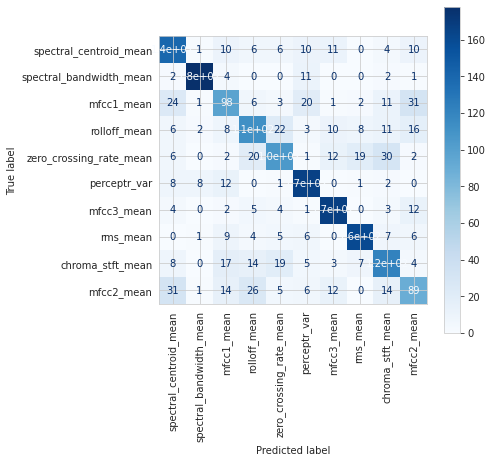

              precision    recall  f1-score   support

       blues      0.611     0.707     0.656       198
   classical      0.927     0.899     0.913       198
     country      0.557     0.497     0.525       197
       disco      0.580     0.566     0.573       198
      hiphop      0.618     0.533     0.572       197
        jazz      0.725     0.838     0.778       198
       metal      0.773     0.843     0.807       198
         pop      0.812     0.808     0.810       198
      reggae      0.590     0.611     0.600       198
        rock      0.520     0.449     0.482       198

    accuracy                          0.675      1978
   macro avg      0.671     0.675     0.672      1978
weighted avg      0.671     0.675     0.672      1978



In [ ]:
# build model using perm selected top 30 features
lr = LogisticRegression()
X_train_perm = X_train[perm_features[:30]]
X_train_rfe = X_train_perm
lr.fit(X_train_perm,y_train)
predictProba(lr, X_train_perm)
predictProba(lr, X_train_perm, dev=True)


In [ ]:
'''# plot correlation among top 30 selected featuers
plt.figure(figsize = (18, 10))
sns.heatmap(X_train_perm.corr(method='spearman'), annot = True, linewidths=.2, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()'''


"# plot correlation among top 30 selected featuers\nplt.figure(figsize = (18, 10))\nsns.heatmap(X_train_perm.corr(method='spearman'), annot = True, linewidths=.2, cmap=sns.diverging_palette(220, 10, as_cmap=True))\nplt.show()"

## Model Building

### Logistic Regression

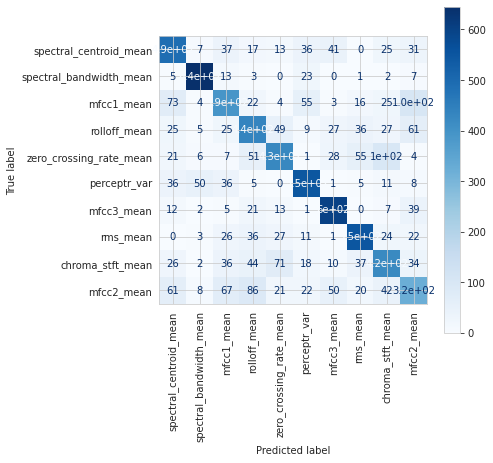

              precision    recall  f1-score   support

       blues      0.656     0.704     0.679       700
   classical      0.881     0.923     0.901       699
     country      0.608     0.560     0.583       698
       disco      0.604     0.622     0.613       699
      hiphop      0.683     0.609     0.644       699
        jazz      0.757     0.783     0.770       700
       metal      0.788     0.857     0.821       700
         pop      0.764     0.786     0.775       700
      reggae      0.616     0.603     0.609       700
        rock      0.508     0.460     0.483       698

    accuracy                          0.691      6993
   macro avg      0.686     0.691     0.688      6993
weighted avg      0.687     0.691     0.688      6993



In [ ]:
lr = LogisticRegression()
lr.fit(X_train_rfe,y_train)
predictProba(lr, X_train_rfe)

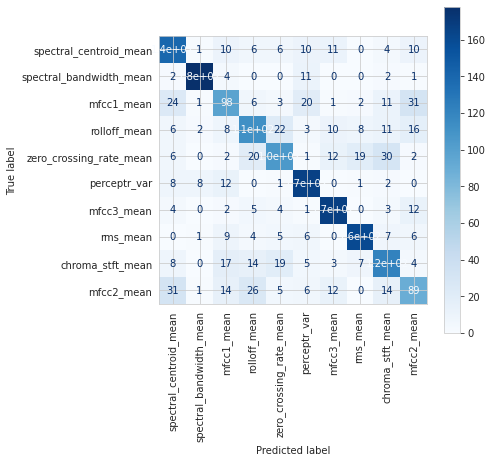

              precision    recall  f1-score   support

       blues      0.611     0.707     0.656       198
   classical      0.927     0.899     0.913       198
     country      0.557     0.497     0.525       197
       disco      0.580     0.566     0.573       198
      hiphop      0.618     0.533     0.572       197
        jazz      0.725     0.838     0.778       198
       metal      0.773     0.843     0.807       198
         pop      0.812     0.808     0.810       198
      reggae      0.590     0.611     0.600       198
        rock      0.520     0.449     0.482       198

    accuracy                          0.675      1978
   macro avg      0.671     0.675     0.672      1978
weighted avg      0.671     0.675     0.672      1978



In [ ]:
predictProba(lr, X_train_rfe, True)

### Random Forest

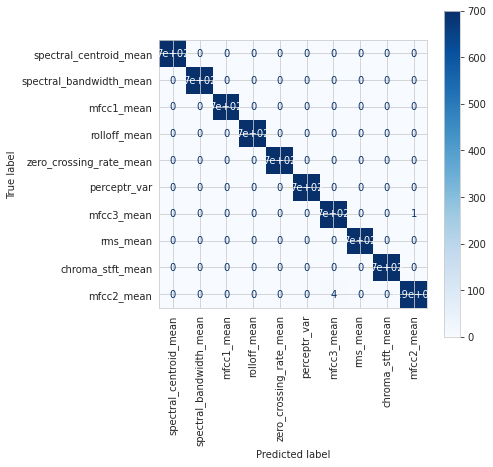

              precision    recall  f1-score   support

       blues      1.000     1.000     1.000       700
   classical      1.000     1.000     1.000       699
     country      1.000     1.000     1.000       698
       disco      1.000     1.000     1.000       699
      hiphop      1.000     1.000     1.000       699
        jazz      1.000     1.000     1.000       700
       metal      0.994     0.999     0.996       700
         pop      1.000     1.000     1.000       700
      reggae      1.000     1.000     1.000       700
        rock      0.999     0.994     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [ ]:
rfc = ske.RandomForestClassifier(random_state=seed, n_jobs=-1)
rfc.fit(X_train_rfe, y_train)
predictProba(rfc, X_train_rfe)

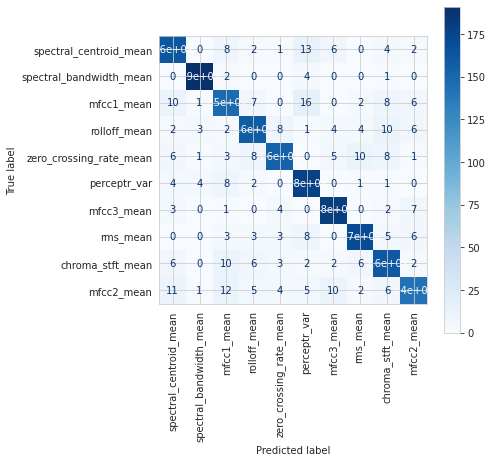

              precision    recall  f1-score   support

       blues      0.794     0.818     0.806       198
   classical      0.950     0.965     0.957       198
     country      0.750     0.746     0.748       197
       disco      0.827     0.798     0.812       198
      hiphop      0.871     0.787     0.827       197
        jazz      0.784     0.899     0.838       198
       metal      0.870     0.914     0.892       198
         pop      0.872     0.859     0.865       198
      reggae      0.782     0.813     0.797       198
        rock      0.826     0.717     0.768       198

    accuracy                          0.832      1978
   macro avg      0.833     0.832     0.831      1978
weighted avg      0.833     0.832     0.831      1978



In [ ]:
predictProba(rfc, X_train_rfe, True)

### AdaBoost

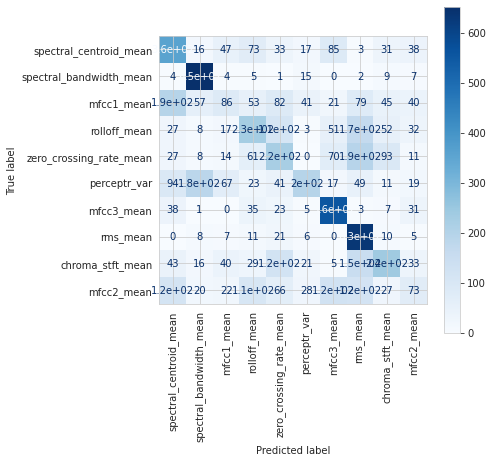

              precision    recall  f1-score   support

       blues      0.397     0.510     0.447       700
   classical      0.672     0.933     0.781       699
     country      0.283     0.123     0.172       698
       disco      0.367     0.329     0.347       699
      hiphop      0.309     0.319     0.314       699
        jazz      0.589     0.279     0.378       700
       metal      0.600     0.796     0.684       700
         pop      0.452     0.903     0.602       700
      reggae      0.457     0.343     0.392       700
        rock      0.253     0.105     0.148       698

    accuracy                          0.464      6993
   macro avg      0.438     0.464     0.426      6993
weighted avg      0.438     0.464     0.427      6993



In [ ]:
abc = ske.AdaBoostClassifier(n_estimators=150, random_state=seed)
abc.fit(X_train_rfe, y_train)
predictProba(abc, X_train_rfe)

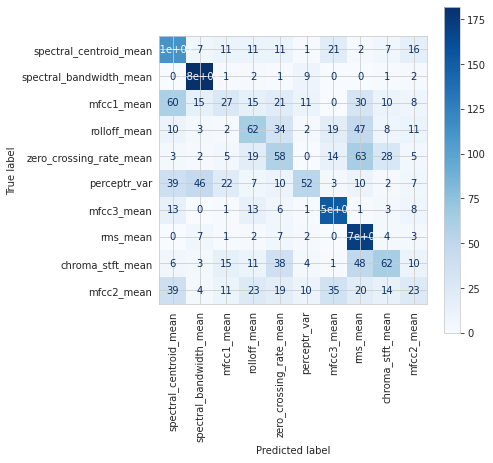

              precision    recall  f1-score   support

       blues      0.395     0.561     0.463       198
   classical      0.677     0.919     0.779       198
     country      0.281     0.137     0.184       197
       disco      0.376     0.313     0.342       198
      hiphop      0.283     0.294     0.289       197
        jazz      0.565     0.263     0.359       198
       metal      0.620     0.768     0.686       198
         pop      0.438     0.869     0.582       198
      reggae      0.446     0.313     0.368       198
        rock      0.247     0.116     0.158       198

    accuracy                          0.456      1978
   macro avg      0.433     0.455     0.421      1978
weighted avg      0.433     0.456     0.421      1978



In [ ]:
predictProba(abc, X_train_rfe, True)

### GBM

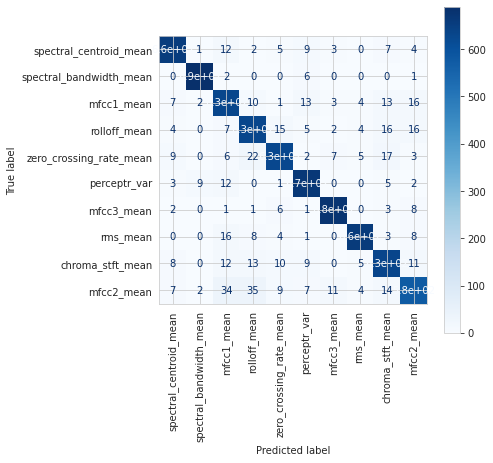

              precision    recall  f1-score   support

       blues      0.943     0.939     0.941       700
   classical      0.980     0.987     0.984       699
     country      0.860     0.901     0.880       698
       disco      0.874     0.901     0.887       699
      hiphop      0.925     0.898     0.911       699
        jazz      0.926     0.954     0.940       700
       metal      0.963     0.969     0.966       700
         pop      0.968     0.943     0.955       700
      reggae      0.890     0.903     0.896       700
        rock      0.893     0.824     0.857       698

    accuracy                          0.922      6993
   macro avg      0.922     0.922     0.922      6993
weighted avg      0.922     0.922     0.922      6993



In [ ]:
gbc = ske.GradientBoostingClassifier(n_estimators=100, random_state=seed)
gbc.fit(X_train_rfe, y_train)
predictProba(gbc, X_train_rfe)

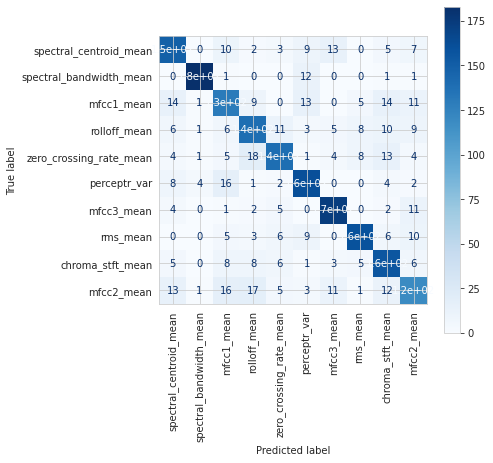

              precision    recall  f1-score   support

       blues      0.734     0.753     0.743       198
   classical      0.958     0.924     0.941       198
     country      0.657     0.660     0.658       197
       disco      0.698     0.702     0.700       198
      hiphop      0.785     0.706     0.743       197
        jazz      0.759     0.813     0.785       198
       metal      0.828     0.874     0.850       198
         pop      0.855     0.803     0.828       198
      reggae      0.700     0.788     0.741       198
        rock      0.661     0.601     0.630       198

    accuracy                          0.762      1978
   macro avg      0.764     0.762     0.762      1978
weighted avg      0.764     0.762     0.762      1978



In [ ]:
predictProba(gbc, X_train_rfe, True)

### XGBoost

In [ ]:
import xgboost as xgb
print(xgb.__version__)


0.90


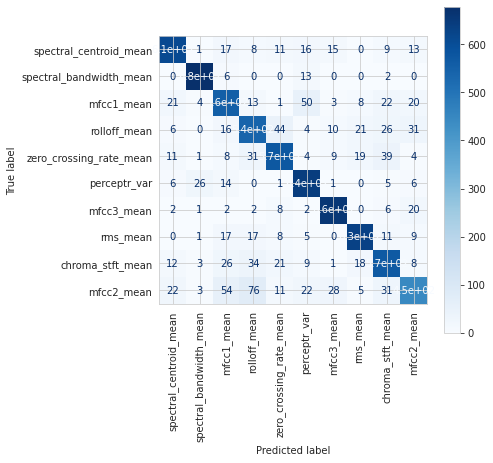

              precision    recall  f1-score   support

       blues      0.884     0.871     0.878       700
   classical      0.944     0.970     0.957       699
     country      0.777     0.797     0.786       698
       disco      0.749     0.774     0.761       699
      hiphop      0.845     0.820     0.832       699
        jazz      0.837     0.916     0.874       700
       metal      0.907     0.939     0.923       700
         pop      0.899     0.903     0.901       700
      reggae      0.790     0.811     0.801       700
        rock      0.801     0.639     0.711       698

    accuracy                          0.844      6993
   macro avg      0.843     0.844     0.842      6993
weighted avg      0.843     0.844     0.842      6993



In [ ]:
xgbc = xgb.XGBClassifier(n_estimators=100, random_state=seed)
xgbc.fit(X_train_rfe, y_train)
predictProba(xgbc, X_train_rfe)

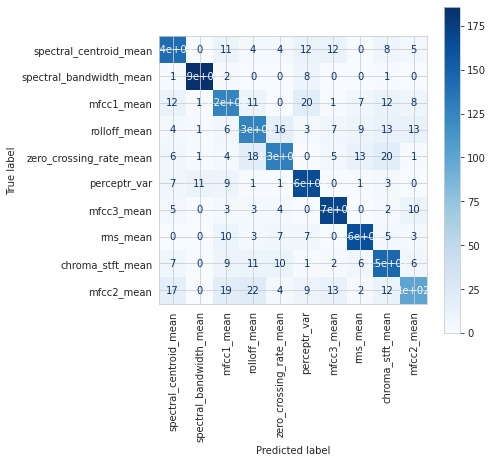

              precision    recall  f1-score   support

       blues      0.706     0.717     0.712       198
   classical      0.930     0.939     0.935       198
     country      0.631     0.635     0.633       197
       disco      0.633     0.636     0.635       198
      hiphop      0.737     0.655     0.694       197
        jazz      0.733     0.833     0.780       198
       metal      0.810     0.864     0.836       198
         pop      0.811     0.823     0.817       198
      reggae      0.658     0.737     0.695       198
        rock      0.685     0.505     0.581       198

    accuracy                          0.735      1978
   macro avg      0.734     0.734     0.732      1978
weighted avg      0.734     0.735     0.732      1978



In [ ]:
predictProba(xgbc, X_train_rfe, True)

### CatBoost

In [ ]:
pip install catboost 


     |████████████████████████████████| 67.3MB 58kB/s 


In [ ]:
import catboost as cb
print(cb.__version__)

0.25.1


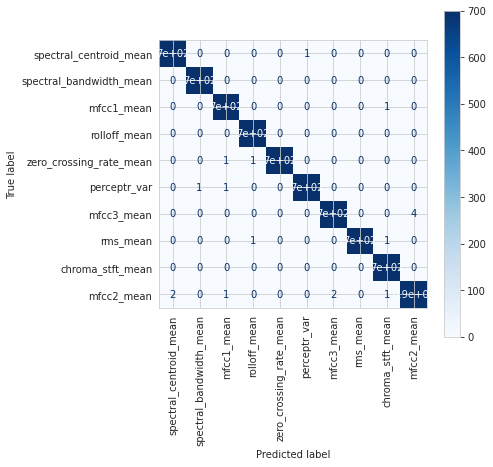

              precision    recall  f1-score   support

       blues      0.997     0.999     0.998       700
   classical      0.999     1.000     0.999       699
     country      0.996     0.999     0.997       698
       disco      0.997     1.000     0.999       699
      hiphop      1.000     0.997     0.999       699
        jazz      0.999     0.997     0.998       700
       metal      0.997     0.994     0.996       700
         pop      1.000     0.997     0.999       700
      reggae      0.996     1.000     0.998       700
        rock      0.994     0.991     0.993       698

    accuracy                          0.997      6993
   macro avg      0.997     0.997     0.997      6993
weighted avg      0.997     0.997     0.997      6993



In [ ]:
cbc = cb.CatBoostClassifier(random_state=seed, verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
cbc.fit(X_train_rfe, y_train)
predictProba(cbc, X_train_rfe)

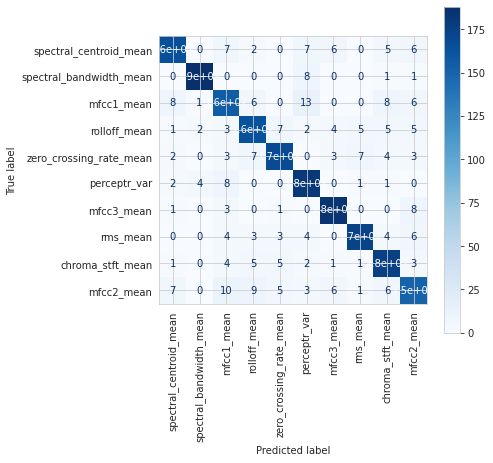

              precision    recall  f1-score   support

       blues      0.882     0.833     0.857       198
   classical      0.964     0.949     0.957       198
     country      0.787     0.787     0.787       197
       disco      0.837     0.828     0.832       198
      hiphop      0.889     0.853     0.870       197
        jazz      0.824     0.919     0.869       198
       metal      0.902     0.934     0.918       198
         pop      0.921     0.879     0.899       198
      reggae      0.838     0.889     0.863       198
        rock      0.799     0.763     0.780       198

    accuracy                          0.863      1978
   macro avg      0.864     0.863     0.863      1978
weighted avg      0.864     0.863     0.863      1978



In [ ]:
predictProba(cbc, X_train_rfe, True)

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as knn


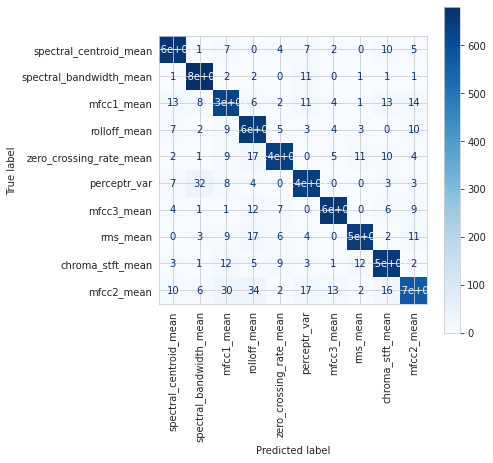

              precision    recall  f1-score   support

       blues      0.934     0.949     0.941       700
   classical      0.925     0.973     0.948       699
     country      0.878     0.897     0.887       698
       disco      0.871     0.938     0.904       699
      hiphop      0.948     0.916     0.932       699
        jazz      0.920     0.919     0.919       700
       metal      0.958     0.943     0.950       700
         pop      0.956     0.926     0.940       700
      reggae      0.914     0.931     0.923       700
        rock      0.906     0.814     0.857       698

    accuracy                          0.920      6993
   macro avg      0.921     0.920     0.920      6993
weighted avg      0.921     0.920     0.920      6993



In [ ]:
cls = knn()
cls2=knn()
cls.fit(X_train_rfe, y_train)
predictProba(cls, X_train_rfe)


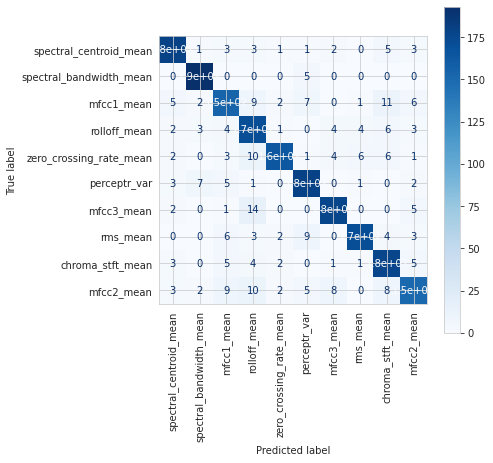

              precision    recall  f1-score   support

       blues      0.899     0.904     0.902       198
   classical      0.928     0.975     0.951       198
     country      0.811     0.782     0.796       197
       disco      0.760     0.864     0.809       198
      hiphop      0.943     0.832     0.884       197
        jazz      0.865     0.904     0.884       198
       metal      0.903     0.889     0.896       198
         pop      0.929     0.864     0.895       198
      reggae      0.816     0.894     0.853       198
        rock      0.844     0.763     0.801       198

    accuracy                          0.867      1978
   macro avg      0.870     0.867     0.867      1978
weighted avg      0.870     0.867     0.867      1978



In [ ]:
predictProba(cls, X_train_rfe, True)

##Model Tuning

### RF Model HP Tuning


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 4)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 60, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

print(random_grid)

{'max_depth': [1, 15, 30, 45, 60],
 'min_samples_split': [5, 10, 15],
 'n_estimators': [10, 140, 270, 400]}


In [ ]:
# Use grid search to find best hyperparameters
rfc_n = ske.RandomForestClassifier(random_state=seed, n_jobs=-1)
rf_random = skms.GridSearchCV(estimator = rfc_n, param_grid=random_grid, cv = 5, verbose=2, n_jobs = -1, scoring='f1_weighted')
# Fit the random search model
rf_random.fit(X_train_rfe, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 16.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=12,
                                    

In [ ]:
# best random model 
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)


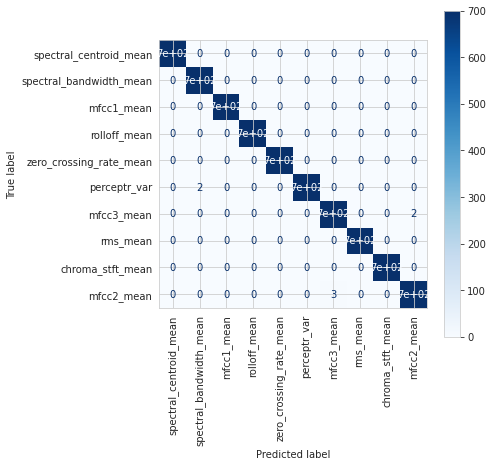

              precision    recall  f1-score   support

       blues      1.000     1.000     1.000       700
   classical      0.997     1.000     0.999       699
     country      1.000     1.000     1.000       698
       disco      1.000     1.000     1.000       699
      hiphop      1.000     1.000     1.000       699
        jazz      1.000     0.997     0.999       700
       metal      0.996     0.997     0.996       700
         pop      1.000     1.000     1.000       700
      reggae      1.000     1.000     1.000       700
        rock      0.997     0.996     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [ ]:
# Performance metrics
predictProba(rf_random.best_estimator_, X_train_rfe)

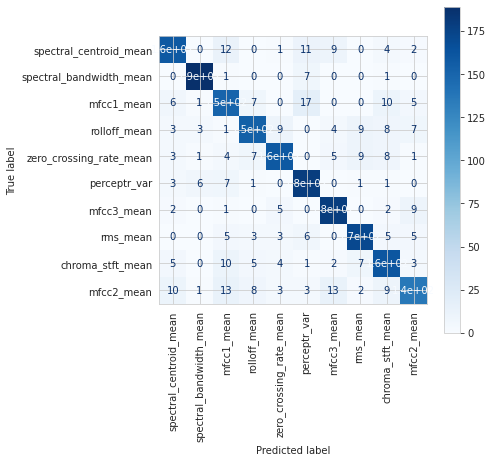

              precision    recall  f1-score   support

       blues      0.832     0.803     0.817       198
   classical      0.940     0.955     0.947       198
     country      0.737     0.766     0.751       197
       disco      0.832     0.778     0.804       198
      hiphop      0.864     0.807     0.835       197
        jazz      0.799     0.904     0.848       198
       metal      0.844     0.904     0.873       198
         pop      0.859     0.864     0.861       198
      reggae      0.770     0.813     0.791       198
        rock      0.810     0.687     0.743       198

    accuracy                          0.828      1978
   macro avg      0.829     0.828     0.827      1978
weighted avg      0.829     0.828     0.827      1978



In [ ]:
predictProba(rf_random.best_estimator_, X_train_rfe, True)

### XGB Model HP Tuning

In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=seed)

xgb_params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

In [ ]:
# Use the random grid to search for best hyperparameters
xgb_random = skms.RandomizedSearchCV(estimator = xgb_model, param_distributions=xgb_params, n_iter=20, cv = 3, verbose=2, n_jobs = -1, random_state=seed, scoring='f1_weighted', return_train_score=True)
# Fit the random search model
xgb_random.fit(X_train_rfe, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=12, reg_alpha=0,
                                           reg_lambda=1, s...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6a93dad350>,
                                        'n_estimator

In [ ]:
# best xgb_random model 
print(xgb_random.best_estimator_)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9066782998097372,
              gamma=0.0016439843761698048, learning_rate=0.3000310498970947,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
              n_estimators=137, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=12, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.6023637423473936, verbosity=1)


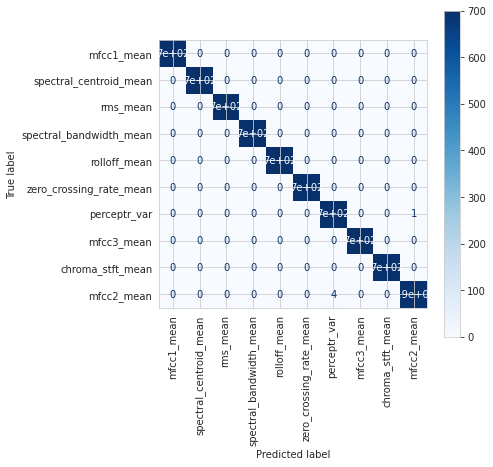

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      1.000     1.000     1.000       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     1.000     1.000       700
           6      0.994     0.999     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.999     0.994     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [ ]:
# Performance metrics
predictProba(xgb_random.best_estimator_, X_train_rfe)

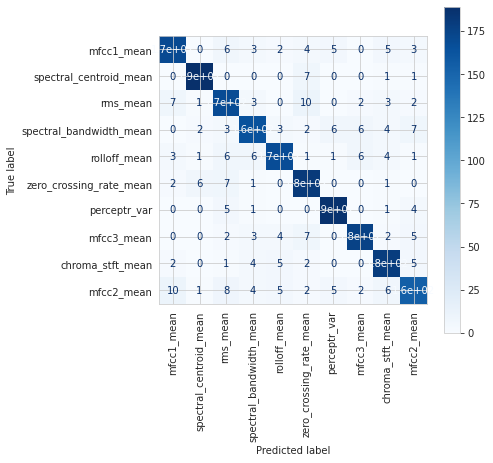

              precision    recall  f1-score   support

           0      0.876     0.859     0.867       198
           1      0.945     0.955     0.950       198
           2      0.816     0.858     0.837       197
           3      0.868     0.833     0.851       198
           4      0.898     0.853     0.875       197
           5      0.838     0.914     0.874       198
           6      0.917     0.944     0.930       198
           7      0.916     0.884     0.900       198
           8      0.869     0.904     0.886       198
           9      0.847     0.783     0.814       198

    accuracy                          0.879      1978
   macro avg      0.879     0.879     0.878      1978
weighted avg      0.879     0.879     0.878      1978



In [ ]:
predictProba(xgb_random.best_estimator_, X_train_rfe, True)

## Model Evaluation

In [ ]:
y_pred_X = rf_random.best_estimator_.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("RF Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

       blues      0.861     0.853     0.857       102
   classical      0.881     0.950     0.914       101
     country      0.778     0.755     0.766       102
       disco      0.830     0.814     0.822       102
      hiphop      0.865     0.814     0.838       102
        jazz      0.835     0.892     0.863       102
       metal      0.896     0.931     0.913       102
         pop      0.893     0.902     0.898       102
      reggae      0.821     0.853     0.837       102
        rock      0.789     0.696     0.740       102

    accuracy                          0.846      1019
   macro avg      0.845     0.846     0.845      1019
weighted avg      0.845     0.846     0.845      1019

RF Test Accuracy - 84.5927379784102


In [ ]:
y_pred_X = xgb_random.best_estimator_.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("XGB Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

       blues      0.890     0.873     0.881       102
   classical      0.905     0.941     0.922       101
     country      0.688     0.755     0.720       102
       disco      0.840     0.824     0.832       102
      hiphop      0.870     0.853     0.861       102
        jazz      0.817     0.873     0.844       102
       metal      0.922     0.922     0.922       102
         pop      0.927     0.873     0.899       102
      reggae      0.899     0.873     0.886       102
        rock      0.771     0.725     0.747       102

    accuracy                          0.851      1019
   macro avg      0.853     0.851     0.851      1019
weighted avg      0.853     0.851     0.851      1019

XGB Test Accuracy - 85.08341511285575


In [ ]:
y_pred_X = cbc.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("CatBoost Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

       blues      0.902     0.902     0.902       102
   classical      0.924     0.960     0.942       101
     country      0.757     0.824     0.789       102
       disco      0.870     0.853     0.861       102
      hiphop      0.935     0.853     0.892       102
        jazz      0.875     0.892     0.883       102
       metal      0.961     0.961     0.961       102
         pop      0.903     0.912     0.907       102
      reggae      0.894     0.912     0.903       102
        rock      0.811     0.755     0.782       102

    accuracy                          0.882      1019
   macro avg      0.883     0.882     0.882      1019
weighted avg      0.883     0.882     0.882      1019

CatBoost Test Accuracy - 88.22374877330716


Here, we had CatBoost as the best model among all ensemble techniques without any HP tuning on the same.

##Load testing data

In [ ]:
audio_fp = 'drive/My Drive/Dataset_music/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)
audio_data = audio_data[:661500]
collection = np.split(audio_data,10)
audio_data = collection[0]

In [ ]:

d = librosa.feature.mfcc(np.array(audio_data).flatten(),sr=22050 , n_mfcc = 20) #36565
d_var = d.var(axis=1).tolist()
d_mean = d.mean(axis=1).tolist()
test_data = []#[d_var + d_mean]
for i in range(20):
  test_data.append(d_mean[i])
  test_data.append(d_var[i])
mfcc_names=[]
for i in range(1,21):
  mfcc_str = "mfcc"+str(i)+"_mean"
  mfcc_names.append(mfcc_str)
  mfcc_str = "mfcc"+str(i)+"_var"
  mfcc_names.append(mfcc_str)
test_frame = pd.DataFrame([test_data], columns = mfcc_names)
test_data = []
mfcc_names=[]
#chroma
S = np.abs(librosa.stft(audio_data, n_fft=4096))**2
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
#chroma_stft_mean
chroma_mean = round(np.mean(chroma),6)
test_data.append(chroma_mean)
#chrome_stft_var
chroma_var = round(np.var(chroma),6)
test_data.append(chroma_var)
#chroma_label
mfcc_names.append("chroma_stft_mean")
mfcc_names.append("chroma_stft_var")

#rms
rms = librosa.feature.rms(y=audio_data)
#rms_mean
rms_mean = round(np.mean(rms),6)
test_data.append(rms_mean)
#rms_var
rms_var = round(np.var(rms),6)
test_data.append(rms_var)
#rms_label
mfcc_names.append("rms_mean")
mfcc_names.append("rms_var")

#spectral_centroid
cent = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
#spectral_centroid_mean
sc_mean = round(np.mean(cent),6)
test_data.append(sc_mean)
#spectral_centroid_var
sc_var = round(np.var(cent),6)
test_data.append(sc_var)
#sc_label
mfcc_names.append("spectral_centroid_mean")
mfcc_names.append("spectral_centroid_var")

#spectral_bandwidth
spec_bw = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
#spectral_bandwidth_mean
spec_bw_mean = round(np.mean(spec_bw),6)
test_data.append(spec_bw_mean)
#spectral_bandwidth_var
spec_bw_var = round(np.var(spec_bw),6)
test_data.append(spec_bw_var)
#sb_label
mfcc_names.append("spectral_bandwidth_mean")
mfcc_names.append("spectral_bandwidth_var")

#rolloff
rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)
#rolloff_mean
rolloff_mean = round(np.mean(rolloff),6)
test_data.append(rolloff_mean)
#rolloff_var
rolloff_var = round(np.var(rolloff),6)
test_data.append(rolloff_var)
#rolloff_label
mfcc_names.append("rolloff_mean")
mfcc_names.append("rolloff_var")

#zero_crossing_rate
zcr = librosa.feature.zero_crossing_rate(audio_data)
#zero_crossing_rate_mean
zcr_mean = round(np.mean(zcr),6)
test_data.append(zcr_mean)
#zero_crossing_rate_var
zcr_var = round(np.var(zcr),6)
test_data.append(zcr_var)
#zero_crossing_rate_label
mfcc_names.append("zero_crossing_rate_mean")
mfcc_names.append("zero_crossing_rate_var")

#harmony
y = librosa.effects.harmonic(audio_data)
harmony = librosa.feature.tonnetz(y=y, sr=sr)
#harmony_mean
harmony_mean = round(np.mean(harmony),6)
test_data.append(harmony_mean) 
#harmony_var
harmony_var = round(np.var(harmony),6)
test_data.append(harmony_var)
#harmony_label
mfcc_names.append("harmony_mean")
mfcc_names.append("harmony_var")

#perceptr_mean
#perceptr_var


#tempo
hop_length = 512
oenv = librosa.onset.onset_strength(y=audio_data, sr=sr, hop_length=hop_length)
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                          hop_length=hop_length)[0]

tempo = round(tempo,6)
test_data.append(tempo)
#tempo_label
mfcc_names.append("tempo")
d_var = d.var(axis=1).tolist()
d_mean = d.mean(axis=1).tolist()
#test_data = []#[d_var + d_mean]
for i in range(20):
  test_data.append(d_mean[i])
  test_data.append(d_var[i])
for i in range(1,21):
  mfcc_str = "mfcc"+str(i)+"_mean"
  mfcc_names.append(mfcc_str)
  mfcc_str = "mfcc"+str(i)+"_var"
  mfcc_names.append(mfcc_str)


test_frame = pd.DataFrame([test_data], columns = mfcc_names)
testing_frame = pd.DataFrame(scaler.transform(test_frame), columns=X_train.columns)
shorter_testing_frame = testing_frame[perm_features[:30]]



shorter_testing_frame.count
  

<bound method DataFrame.count of    spectral_centroid_mean  spectral_bandwidth_mean  ...  mfcc5_var  chroma_stft_var
0               -0.571196                -0.493776  ...   0.074582         0.494271

[1 rows x 30 columns]>

In [ ]:
val=1
while(val<=9):
  audio_data = collection[val]
  d = librosa.feature.mfcc(np.array(audio_data).flatten(),sr=22050 , n_mfcc = 20) #36565
  d_var = d.var(axis=1).tolist()
  d_mean = d.mean(axis=1).tolist()
  test_data = []#[d_var + d_mean]
  for i in range(20):
    test_data.append(d_mean[i])
    test_data.append(d_var[i])
  mfcc_names=[]
  for i in range(1,21):
    mfcc_str = "mfcc"+str(i)+"_mean"
    mfcc_names.append(mfcc_str)
    mfcc_str = "mfcc"+str(i)+"_var"
    mfcc_names.append(mfcc_str)
  test_frame = pd.DataFrame([test_data], columns = mfcc_names)
  test_data = []
  mfcc_names=[]
  #chroma
  S = np.abs(librosa.stft(audio_data, n_fft=4096))**2
  chroma = librosa.feature.chroma_stft(S=S, sr=sr)
  #chroma_stft_mean
  chroma_mean = round(np.mean(chroma),6)
  test_data.append(chroma_mean)
  #chrome_stft_var
  chroma_var = round(np.var(chroma),6)
  test_data.append(chroma_var)
  #chroma_label
  mfcc_names.append("chroma_stft_mean")
  mfcc_names.append("chroma_stft_var")

  #rms
  rms = librosa.feature.rms(y=audio_data)
  #rms_mean
  rms_mean = round(np.mean(rms),6)
  test_data.append(rms_mean)
  #rms_var
  rms_var = round(np.var(rms),6)
  test_data.append(rms_var)
  #rms_label
  mfcc_names.append("rms_mean")
  mfcc_names.append("rms_var")

  #spectral_centroid
  cent = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
  #spectral_centroid_mean
  sc_mean = round(np.mean(cent),6)
  test_data.append(sc_mean)
  #spectral_centroid_var
  sc_var = round(np.var(cent),6)
  test_data.append(sc_var)
  #sc_label
  mfcc_names.append("spectral_centroid_mean")
  mfcc_names.append("spectral_centroid_var")

  #spectral_bandwidth
  spec_bw = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
  #spectral_bandwidth_mean
  spec_bw_mean = round(np.mean(spec_bw),6)
  test_data.append(spec_bw_mean)
  #spectral_bandwidth_var
  spec_bw_var = round(np.var(spec_bw),6)
  test_data.append(spec_bw_var)
  #sb_label
  mfcc_names.append("spectral_bandwidth_mean")
  mfcc_names.append("spectral_bandwidth_var")

  #rolloff
  rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)
  #rolloff_mean
  rolloff_mean = round(np.mean(rolloff),6)
  test_data.append(rolloff_mean)
  #rolloff_var
  rolloff_var = round(np.var(rolloff),6)
  test_data.append(rolloff_var)
  #rolloff_label
  mfcc_names.append("rolloff_mean")
  mfcc_names.append("rolloff_var")

  #zero_crossing_rate
  zcr = librosa.feature.zero_crossing_rate(audio_data)
  #zero_crossing_rate_mean
  zcr_mean = round(np.mean(zcr),6)
  test_data.append(zcr_mean)
  #zero_crossing_rate_var
  zcr_var = round(np.var(zcr),6)
  test_data.append(zcr_var)
  #zero_crossing_rate_label
  mfcc_names.append("zero_crossing_rate_mean")
  mfcc_names.append("zero_crossing_rate_var")

  #harmony
  y = librosa.effects.harmonic(audio_data)
  harmony = librosa.feature.tonnetz(y=y, sr=sr)
  #harmony_mean
  harmony_mean = round(np.mean(harmony),6)
  test_data.append(harmony_mean) 
  #harmony_var
  harmony_var = round(np.var(harmony),6)
  test_data.append(harmony_var)
  #harmony_label
  mfcc_names.append("harmony_mean")
  mfcc_names.append("harmony_var")

  #perceptr_mean
  #perceptr_var


  #tempo
  hop_length = 512
  oenv = librosa.onset.onset_strength(y=audio_data, sr=sr, hop_length=hop_length)
  tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                            hop_length=hop_length)[0]

  tempo = round(tempo,6)
  test_data.append(tempo)
  #tempo_label
  mfcc_names.append("tempo")
  d_var = d.var(axis=1).tolist()
  d_mean = d.mean(axis=1).tolist()
  #test_data = []#[d_var + d_mean]
  for i in range(20):
    test_data.append(d_mean[i])
    test_data.append(d_var[i])
  for i in range(1,21):
    mfcc_str = "mfcc"+str(i)+"_mean"
    mfcc_names.append(mfcc_str)
    mfcc_str = "mfcc"+str(i)+"_var"
    mfcc_names.append(mfcc_str)


  test_frame2 = pd.DataFrame([test_data], columns = mfcc_names)
  testing_frame2 = pd.DataFrame(scaler.transform(test_frame2), columns=X_train.columns)
  shorter_testing_frame2 = testing_frame2[perm_features[:30]]
  df_test = pd.concat([shorter_testing_frame, shorter_testing_frame2])
  shorter_testing_frame = df_test
  val+=1

df_test.count

<bound method DataFrame.count of    spectral_centroid_mean  spectral_bandwidth_mean  ...  mfcc5_var  chroma_stft_var
0               -0.571196                -0.493776  ...   0.074582         0.494271
0               -0.531038                -0.356501  ...   0.025496        -0.022521
0               -0.676314                -0.442035  ...   0.059573         0.102364
0               -0.517746                -0.344976  ...  -0.174463         0.270007
0               -0.524411                -0.399346  ...   0.116119         0.358273
0               -0.489677                -0.428123  ...   0.350802         0.213279
0               -0.542709                -0.493464  ...   0.358830         0.306943
0               -0.618394                -0.601025  ...   0.505047         0.015474
0               -0.594346                -0.662359  ...   0.175072         0.383144
0               -0.583425                -0.674662  ...  -0.124875        -0.746221

[10 rows x 30 columns]>

In [ ]:
#df_test.drop(df_test.index, inplace=True)


## Testing Input data

0 : blues \
1 : pop  \
2 : jazz \
3 : reggae \
4 : metal \
5 : disco \
6 : classical \
7 : hiphop \
8 : rock \
9 : country

In [ ]:
from collections import Counter
result_list=[]
models = {'Catboost':cbc, 'XGBoost':xgbc, 'Gradient Boosting':gbc, 'AdaBoost':abc, 'Random Forest':rfc, 'Linear Regression':lr, 'KNN':cls}
key_list = list(models.keys())
val_list = list(models.values())
 



for model in models.values():
  position = val_list.index(model)
  for i in range(10):
    test = model.predict(df_test[i:(i+1)])
    result_list.append(test)
  t = max(result_list, key = result_list.count)

  
  if t== [[0]] or t ==[['blues']]:
    genre_detected = 'blues'
  elif t== [[1]] or t==[['pop']]:
    genre_detected = 'pop'
  elif t== [[2]] or t==[['jazz']]:
    genre_detected = 'jazz'
  elif t== [[3]] or t==[['reggae']]:
    genre_detected = 'reggae'
  elif t== [[4]] or t==[['metal']]:
    genre_detected = 'metal'
  elif t== [[5]] or t==[['disco']]:
    genre_detected = 'disco'
  elif t== [[6]] or t==[['classical']]:
    genre_detected = 'classical'
  elif t== [[7]] or t==[['hiphop']]:
    genre_detected = 'hiphop'
  elif t== [[8]] or t==[['rock']]:
   genre_detected = 'rock'
  else:
    genre_detected = 'country'
  print("The tested genre with {} model is:  {}".format(key_list[position], genre_detected))


[['blues']]
[['blues']]
[['blues']]
[['disco']]
[['blues']]
[['country']]
[['blues']]
[['blues']]
[['blues']]
[['blues']]
The tested genre with Catboost model is:  blues
['blues']
['blues']
['blues']
['country']
['blues']
['country']
['country']
['blues']
['blues']
['blues']
The tested genre with XGBoost model is:  blues
['blues']
['blues']
['blues']
['country']
['blues']
['country']
['country']
['country']
['blues']
['blues']
The tested genre with Gradient Boosting model is:  blues
['blues']
['blues']
['blues']
['blues']
['blues']
['blues']
['blues']
['blues']
['blues']
['blues']
The tested genre with AdaBoost model is:  blues
['blues']
['blues']
['blues']
['country']
['blues']
['blues']
['blues']
['blues']
['blues']
['blues']
The tested genre with Random Forest model is:  blues
['disco']
['blues']
['disco']
['disco']
['disco']
['disco']
['blues']
['blues']
['blues']
['blues']
The tested genre with Linear Regression model is:  blues
['blues']
['blues']
['blues']
['blues']
['blues']
['